# Import libraries

In [1]:
import itertools
import math
from functools import partial
from typing import Any

import pandas as pd
import numpy as np
import networkx as nx
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch_geometric.loader import DataLoader as GDataLoader
import torch_geometric.nn as nng
from tsl.data import Data as TData
from tsl.nn.blocks import MLP, MLPDecoder
from tsl.nn import get_functional_activation
from tsl.nn.layers import GraphConv, DenseGraphConv

from tsl.nn.blocks.encoders import RNN
from tsl.nn.blocks.decoders import GCNDecoder
from einops.layers.torch import Rearrange  # reshape data with Einstein notation
import pytorch_lightning as L

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import TargetEncoder
from scipy.sparse import coo_matrix
from torch_geometric_temporal.signal import DynamicGraphTemporalSignal, temporal_signal_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# Build satellite graph

## Load satellite graph node data

In [2]:
reduced, frac1 = False, 0.25
reduced_sample_alt_e, frac2, min_alt, max_alt, e_thres, sampled1 = False, 1.0, 500, 600, 0.2, False
reduced_sample_leos, frac3, leo, sampled2, = True, 0.25, 'leo4', True  # smallest LEO
if reduced:
    nodes_savepath = f"../datasets/space-track-ap2-graph-node-feats-reduced-{int(frac1 * 100)}.csv"
elif reduced_sample_alt_e:
    if sampled1:
        nodes_savepath = f"../datasets/space-track-ap2-graph-node-feats-reduced-{int(frac2 * 100)}-h-{min_alt}-{max_alt}-e-{int(e_thres * 100)}.csv"
    else:
        nodes_savepath = f"../datasets/space-track-ap2-graph-node-feats-reduced-h-{min_alt}-{max_alt}-e-{int(e_thres * 100)}.csv"
elif reduced_sample_leos:
    if sampled2:
        nodes_savepath = f"../datasets/space-track-ap2-graph-node-feats-{leo}-reduced-{int(frac3 * 100)}.csv"
    else:
        nodes_savepath = f"../datasets/space-track-ap2-graph-node-feats-{leo}.csv"
else:
    nodes_savepath = '../datasets/space-track-ap2-graph-node-feats.csv'

nodes_df = pd.read_csv(nodes_savepath, memory_map=True).set_index('NORAD_CAT_ID').drop(
    ['OBJECT_NAME', 'OBJECT_ID', 'DECAY_DATE', 'CENTER_NAME', 'REF_FRAME', 'TIME_SYSTEM', 'MEAN_ELEMENT_THEORY'],
    axis=1).fillna({'CONSTELLATION_DISCOS_ID': 0})
nodes_df.head()

,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,EPHEMERIS_TYPE,CLASSIFICATION_TYPE,REV_AT_EPOCH,BSTAR,...,OBJECT_TYPE,RCS_SIZE,CONSTELLATION_DISCOS_ID,PX,PY,PZ,VX,VY,VZ,TIMESTAMP
NORAD_CAT_ID,,,,,,,,,,,,,,,,,,,,,
53,12.173182,0.009849,47.2749,245.136139,290.259668,93.520449,0,U,82552,0.001154,...,DEBRIS,MEDIUM,0.0,-981.739653,-7532.454068,2463.445980,5.185705,0.803544,4.730939,2023-12-28 00:00:00
1314,12.917792,0.003186,90.2439,346.489073,121.537524,93.047660,0,U,51454,0.000067,...,PAYLOAD,LARGE,0.0,-6109.304395,1487.265525,-4410.214654,4.005457,-0.936573,-5.909974,2023-12-28 00:00:00
1570,12.527797,0.010160,56.0579,38.416745,177.606018,281.664377,0,U,66873,0.000116,...,PAYLOAD,MEDIUM,0.0,-3549.131956,2696.045132,6411.820026,-5.164112,-4.866150,-0.897586,2023-12-28 00:00:00
1573,12.410282,0.006615,56.0518,218.083507,320.617156,261.950267,0,U,64321,0.000149,...,PAYLOAD,MEDIUM,0.0,2808.836400,5941.159037,-4370.626680,-5.568033,-0.634834,-4.361757,2023-12-28 00:00:00
1574,12.370203,0.006564,56.0539,282.997424,126.316083,331.609578,0,U,63479,0.000209,...,PAYLOAD,MEDIUM,0.0,4000.103782,1984.830449,6449.951328,-2.117379,6.781488,-0.799534,2023-12-28 00:00:00


## One-hot encode Categorical columns

In [3]:
nodes_df = pd.get_dummies(nodes_df, columns=['EPHEMERIS_TYPE', 'CLASSIFICATION_TYPE', 'OBJECT_TYPE', 'RCS_SIZE'],
                          drop_first=False, dummy_na=True, dtype=float)
nodes_df.head()

,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,REV_AT_EPOCH,BSTAR,MEAN_MOTION_DOT,MEAN_MOTION_DDOT,...,CLASSIFICATION_TYPE_U,CLASSIFICATION_TYPE_nan,OBJECT_TYPE_DEBRIS,OBJECT_TYPE_PAYLOAD,OBJECT_TYPE_ROCKET BODY,OBJECT_TYPE_nan,RCS_SIZE_LARGE,RCS_SIZE_MEDIUM,RCS_SIZE_SMALL,RCS_SIZE_nan
NORAD_CAT_ID,,,,,,,,,,,,,,,,,,,,,
53,12.173182,0.009849,47.2749,245.136139,290.259668,93.520449,82552,0.001154,2.917841e-11,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1314,12.917792,0.003186,90.2439,346.489073,121.537524,93.047660,51454,0.000067,2.298905e-11,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1570,12.527797,0.010160,56.0579,38.416745,177.606018,281.664377,66873,0.000116,-6.896714e-11,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1573,12.410282,0.006615,56.0518,218.083507,320.617156,261.950267,64321,0.000149,-6.366198e-11,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1574,12.370203,0.006564,56.0539,282.997424,126.316083,331.609578,63479,0.000209,-5.747262e-11,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


## Load satellite graph edges data

In [4]:
edges_df = pd.read_csv(nodes_savepath.replace('node-feats', 'edges'), memory_map=True).rename(
    columns={'datetime': 'timestamp'})
edges_df.head()

,source,target,weight,r_dist,it_dist,ct_dist,dist,timestamp,prop
0,53,8168,1,4.207451e+06,3.649788e+06,1660.927964,5.569883e+06,2023-12-28 00:00:00,True
1,13527,48242,1,6.600881e+06,1.241215e+07,1445.055658,1.405820e+07,2023-12-28 00:00:00,True
2,13538,16456,1,3.261385e+05,2.032948e+06,1392.352587,2.058943e+06,2023-12-28 00:00:00,True
3,13538,19785,1,1.241162e+06,7.666014e+06,1561.350018,7.765839e+06,2023-12-28 00:00:00,True
4,13766,16456,1,4.163467e+04,1.124264e+07,636.122198,1.124272e+07,2023-12-28 00:00:00,True


In [5]:
timestamps = edges_df['timestamp'].unique()
print(timestamps)
print(timestamps.size)

['2023-12-28 00:00:00' '2023-12-28 01:00:00' '2023-12-28 02:00:00'
 '2023-12-28 03:00:00' '2023-12-28 04:00:00' '2023-12-28 05:00:00'
 '2023-12-28 06:00:00' '2023-12-28 07:00:00' '2023-12-28 08:00:00'
 '2023-12-28 09:00:00' '2023-12-28 10:00:00' '2023-12-28 11:00:00'
 '2023-12-28 12:00:00' '2023-12-28 13:00:00' '2023-12-28 14:00:00'
 '2023-12-28 15:00:00' '2023-12-28 16:00:00' '2023-12-28 17:00:00'
 '2023-12-28 18:00:00' '2023-12-28 19:00:00' '2023-12-28 20:00:00'
 '2023-12-28 21:00:00' '2023-12-28 22:00:00' '2023-12-28 23:00:00'
 '2023-12-29 00:00:00' '2023-12-29 01:00:00' '2023-12-29 02:00:00'
 '2023-12-29 03:00:00' '2023-12-29 04:00:00' '2023-12-29 05:00:00'
 '2023-12-29 06:00:00' '2023-12-29 07:00:00' '2023-12-29 08:00:00'
 '2023-12-29 09:00:00' '2023-12-29 10:00:00' '2023-12-29 11:00:00'
 '2023-12-29 12:00:00' '2023-12-29 13:00:00' '2023-12-29 14:00:00'
 '2023-12-29 15:00:00' '2023-12-29 16:00:00' '2023-12-29 17:00:00'
 '2023-12-29 18:00:00' '2023-12-29 19:00:00' '2023-12-29 20:00

# Satellite Conjunction Prediction through Link Prediction

## Separate satellite graph edges into train set and test set

In [6]:
def temporal_signal_split(timestamps, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2):
    train_snapshots = int(train_ratio * timestamps.shape[0])
    # necessary to reduce len(train_timestamps) timestamps to 1 such that there is only one feature matrix
    train_snapshots = train_snapshots - 1 if train_snapshots % 2 == 0 else train_snapshots
    val_snapshots = int(val_ratio * timestamps.shape[0])

    test_snapshots_start = train_snapshots + val_snapshots

    train_timestamps = timestamps[0:train_snapshots]
    val_timestamps = timestamps[train_snapshots:test_snapshots_start]
    test_timestamps = timestamps[test_snapshots_start:]

    return train_timestamps, val_timestamps, test_timestamps


train_timestamps, val_timestamps, test_timestamps = temporal_signal_split(timestamps)

train_edges_df = edges_df[edges_df['timestamp'].isin(train_timestamps)]
val_edges_df = edges_df[edges_df['timestamp'].isin(val_timestamps)]
test_edges_df = edges_df[edges_df['timestamp'].isin(test_timestamps)]

print(
    f"Number of train timestamps: {train_timestamps.shape[0]}\n"
    f"Number of validation timestamps: {val_timestamps.shape[0]}\n"
    f"Number of test timestamps: {test_timestamps.shape[0]}"
)

Number of train timestamps: 445
Number of validation timestamps: 148
Number of test timestamps: 151


## Separate each set of edges into positive edges and negative edges

In [7]:
nodes = list(nodes_df.index.unique())

In [8]:
def sample_negative_edges_df_for_dt(nodes, positive_edges_df_in_dt, date_time):
    positive_set = set(positive_edges_df_in_dt[["source", "target"]].itertuples(index=False, name=None))

    def valid_neg_edge(src, tgt):
        return (
            # no self-loops
                src != tgt
                and
                # neither direction of the edge should be a positive one
                (src, tgt) not in positive_set
                and (tgt, src) not in positive_set
        )

    # TODO: Define edge weight and assing random weight here
    possible_neg_edges = [
        [src, tgt, 1, date_time] for src in nodes for tgt in nodes if valid_neg_edge(src, tgt)
    ]
    neg_edges = np.array(random.sample(possible_neg_edges, k=len(positive_set)))
    return {'source': neg_edges[:, 0].tolist(), 'target': neg_edges[:, 1].tolist(), 'weight': neg_edges[:, 2].tolist(),
            'timestamp': neg_edges[:, 3].tolist()}


def sample_negative_edges_df(nodes, positive_edges_df, timestamps):
    edges = {'source': [], 'target': [], 'weight': [], 'timestamp': []}
    for i in tqdm(range(len(timestamps))):
        date_time = timestamps[i]
        edges_data = sample_negative_edges_df_for_dt(nodes,
                                                     positive_edges_df[positive_edges_df['timestamp'] == date_time],
                                                     date_time)
        edges['source'] = edges['source'] + edges_data['source']
        edges['target'] = edges['target'] + edges_data['target']
        edges['weight'] = edges['weight'] + edges_data['weight']
        edges['timestamp'] = edges['timestamp'] + edges_data['timestamp']
    edges_df = pd.DataFrame(edges)
    edges_df['source'] = edges_df['source'].astype(np.int64)
    edges_df['target'] = edges_df['target'].astype(np.int64)
    edges_df['weight'] = edges_df['weight'].astype(np.int64)
    edges_df['timestamp'] = pd.to_datetime(edges_df['timestamp'])
    return edges_df


train_pos_edges_df = train_edges_df[['source', 'target', 'weight', 'timestamp']]
train_neg_edges_df = sample_negative_edges_df(nodes, train_pos_edges_df, train_timestamps)

val_pos_edges_df = val_edges_df[['source', 'target', 'weight', 'timestamp']]
val_neg_edges_df = sample_negative_edges_df(nodes, val_pos_edges_df, val_timestamps)

test_pos_edges_df = test_edges_df[['source', 'target', 'weight', 'timestamp']]
test_neg_edges_df = sample_negative_edges_df(nodes, test_pos_edges_df, test_timestamps)

print(
    f"Number of total positive edges in training set: {train_pos_edges_df.shape[0]}\n"
    f"Number of total negative edges in training set: {train_neg_edges_df.shape[0]}\n"
    f"Number of total positive edges in validation set: {val_pos_edges_df.shape[0]}\n"
    f"Number of total negative edges in validation set: {val_neg_edges_df.shape[0]}\n"
    f"Number of total positive edges in test set: {test_pos_edges_df.shape[0]}\n"
    f"Number of total negative edges in test set: {test_neg_edges_df.shape[0]}\n"
)

  0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

Number of total positive edges in training set: 84907
Number of total negative edges in training set: 84907
Number of total positive edges in validation set: 27759
Number of total negative edges in validation set: 27759
Number of total positive edges in test set: 28133
Number of total negative edges in test set: 28133



## Transform to torch_geometric.data.Data

In [9]:
def feat_idx_w(num_nodes, node_index, nodes_df, edges_df):
    x = nodes_df.values[:, :].astype(float)

    # Convert DataFrame to COO format
    row = edges_df['source'].map(node_index.get)
    col = edges_df['target'].map(node_index.get)
    data = [1] * len(edges_df)
    coo = coo_matrix((data, (row, col)), shape=(num_nodes, num_nodes))
    edge_index = np.array([coo.row, coo.col], dtype=np.int64)

    edge_attr = edges_df['weight'].values.astype(float)

    return torch.tensor(x), torch.tensor(edge_index), torch.tensor(edge_attr)


def to_feats_idxs_ws(timestamps, num_nodes, node_index, nodes_df, edges_df):
    features = []
    edge_indices = []
    edge_weights = []
    for ts in tqdm(timestamps):
        nodes_df_ts = nodes_df[nodes_df['TIMESTAMP'] == ts]
        edges_df_ts = edges_df[edges_df['timestamp'] == ts]

        x, edge_index, edge_attr = feat_idx_w(num_nodes, node_index, nodes_df_ts.drop('TIMESTAMP', axis=1), edges_df_ts)
        features.append(x)
        edge_indices.append(edge_index)
        edge_weights.append(edge_attr)
    return features, edge_indices, edge_weights


num_nodes = len(nodes)
node_index = {node: i for i, node in enumerate(nodes)}

train_pos_data = to_feats_idxs_ws(train_timestamps, num_nodes, node_index, nodes_df, train_pos_edges_df)
train_neg_data = to_feats_idxs_ws(train_timestamps, num_nodes, node_index, nodes_df, train_neg_edges_df)

val_pos_data = to_feats_idxs_ws(val_timestamps, num_nodes, node_index, nodes_df, val_pos_edges_df)
val_neg_data = to_feats_idxs_ws(val_timestamps, num_nodes, node_index, nodes_df, val_neg_edges_df)

test_pos_data = to_feats_idxs_ws(test_timestamps, num_nodes, node_index, nodes_df, test_pos_edges_df)
test_neg_data = to_feats_idxs_ws(test_timestamps, num_nodes, node_index, nodes_df, test_neg_edges_df)

  0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

## Discrete-Time Dynamic Graph Windowed Dataset

In [10]:
class DTDGLinkDataset(torch.utils.data.Dataset):
    def __init__(self, pos_data, neg_data, window=11, horizon=1, stride=1):
        self.pos_xs, self.pos_edge_idxs, self.pos_edge_attrs = pos_data
        self.neg_xs, self.neg_edge_idxs, self.neg_edge_attrs = neg_data
        self.num_nodes = self.pos_xs[0].size()[0]
        self.window = window
        self.horizon = horizon
        self.stride = stride
        self.tot_samples = math.ceil((len(self.pos_xs) - (self.window + self.horizon)) / self.stride)

    def __len__(self):
        return self.tot_samples

    def __getitem__(self, idx):
        start = idx * self.stride
        end = start + self.window + self.horizon

        sample_pos_xs, sample_pos_edge_idxs, sample_pos_edge_attrs = self.pos_xs[start: end], self.pos_edge_idxs[
                                                                                              start: end], self.pos_edge_attrs[
                                                                                                           start: end]
        sample_neg_xs, sample_neg_edge_idxs, sample_neg_edge_attrs = self.neg_xs[start: end], self.neg_edge_idxs[
                                                                                              start: end], self.neg_edge_attrs[
                                                                                                           start: end]

        window_pos_xs, window_pos_edge_idxs, window_pos_edge_attrs = sample_pos_xs[:self.window], sample_pos_edge_idxs[
                                                                                                  :self.window], sample_pos_edge_attrs[
                                                                                                                 :self.window]
        window_neg_xs, window_neg_edge_idxs, window_neg_edge_attrs = sample_neg_xs[:self.window], sample_neg_edge_idxs[
                                                                                                  :self.window], sample_neg_edge_attrs[
                                                                                                                 :self.window]

        target_pos_xs, target_pos_edge_idxs, target_pos_edge_attrs = sample_pos_xs[-1], sample_pos_edge_idxs[-1], \
        sample_pos_edge_attrs[-1]
        target_neg_xs, target_neg_edge_idxs, target_neg_edge_attrs = sample_neg_xs[-1], sample_neg_edge_idxs[-1], \
        sample_neg_edge_attrs[-1]
        input = dict(
            pos_x=torch.stack(window_pos_xs),
            neg_x=torch.stack(window_neg_xs)
        )
        target = dict(
            pos_y=torch.stack(target_pos_xs) if self.horizon > 1 else torch.stack([target_pos_xs]),
            neg_y=torch.stack(target_neg_xs) if self.horizon > 1 else torch.stack([target_neg_xs])
        )
        edge_index = dict(
            input_pos_ei=window_pos_edge_idxs,
            input_neg_ei=window_neg_edge_idxs,
            target_pos_ei=target_pos_edge_idxs,
            target_neg_ei=target_neg_edge_idxs,
        )
        edge_weight = dict(
            input_pos_w=window_pos_edge_attrs,
            input_neg_w=window_neg_edge_attrs,
            target_pos_w=target_pos_edge_attrs,
            target_neg_w=target_neg_edge_attrs,
        )

        return TData(input=input, target=target, edge_index=edge_index, edge_weight=edge_weight,
                     num_nodes=self.num_nodes)

In [11]:
window = 16  # should be < len(train_pos_data[0]) train_pos_data[0] == pos_xs
horizon = 1
shuffle = False
batch_size = 1

train_dataset = DTDGLinkDataset(train_pos_data, train_neg_data, window=window, horizon=horizon)
train_loader = GDataLoader(train_dataset, shuffle=shuffle, batch_size=batch_size)
batch = next(iter(train_loader))
print(batch)

val_dataset = DTDGLinkDataset(val_pos_data, val_neg_data, window=window, horizon=horizon)
val_loader = GDataLoader(val_dataset, shuffle=shuffle, batch_size=batch_size)
batch = next(iter(val_loader))
print(batch)

DataBatch(
  input=(pos_x=[16, 801, 33], neg_x=[16, 801, 33]),
  target=(pos_y=[1, 801, 33], neg_y=[1, 801, 33]),
  has_mask=False
)
DataBatch(
  input=(pos_x=[16, 801, 33], neg_x=[16, 801, 33]),
  target=(pos_y=[1, 801, 33], neg_y=[1, 801, 33]),
  has_mask=False
)


## PyTorch STGNN

In [12]:
class TemporalConv(nn.Module):
    r""" Implementation from PyTorch Geometric Temporal.
    Temporal convolution block applied to nodes in the STGCN Layer
    For details see: `"Spatio-Temporal Graph Convolutional Networks:
    A Deep Learning Framework for Traffic Forecasting."
    <https://arxiv.org/abs/1709.04875>`_ Based off the temporal convolution
     introduced in "Convolutional Sequence to Sequence Learning"  <https://arxiv.org/abs/1709.04875>`_

    Args:
        in_channels (int): Number of input features.
        out_channels (int): Number of output features.
        kernel_size (int): Convolutional kernel size.
    """

    def __init__(self, in_channels: int, out_channels: int, kernel_size: int = 3):
        super(TemporalConv, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels, out_channels, (1, kernel_size))
        self.conv_2 = nn.Conv2d(in_channels, out_channels, (1, kernel_size))
        self.conv_3 = nn.Conv2d(in_channels, out_channels, (1, kernel_size))

    def forward(self, X: torch.FloatTensor) -> torch.FloatTensor:
        # X = X.permute(0, 3, 2, 1)
        # P = self.conv_1(X)
        # Q = torch.sigmoid(self.conv_2(X))
        # PQ = P * Q
        # H = F.relu(PQ + self.conv_3(X))
        # H = H.permute(0, 3, 2, 1)
        # return H
        X = X.permute(0, 3, 2, 1)
        P = self.conv_1(X)
        Q = torch.sigmoid(self.conv_2(X))
        PQ = P * Q
        H = F.relu(PQ + self.conv_3(X))
        H = H.permute(0, 3, 2, 1)
        return H


class STConv(nn.Module):

    def __init__(
            self,
            graph_conv: nn.Module,
            num_nodes: int,
            in_channels: int,
            hidden_channels: int,
            out_channels: int,
            kernel_size: int,
            K: int,
            normalization: str = "sym",
            bias: bool = True,
    ):
        super(STConv, self).__init__()
        self.num_nodes = num_nodes
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.K = K
        self.normalization = normalization
        self.bias = bias

        self._temporal_conv1 = TemporalConv(
            in_channels=in_channels,
            out_channels=hidden_channels,
            kernel_size=kernel_size,
        )

        #self._graph_conv = graph_conv

        self._graph_conv = nng.ChebConv(
            in_channels=hidden_channels,
            out_channels=hidden_channels,
            K=K,
            normalization=normalization,
            bias=bias,
        )

        self._temporal_conv2 = TemporalConv(
            in_channels=hidden_channels,
            out_channels=hidden_channels,
            kernel_size=kernel_size,
        )
        self.decoder = MLPDecoder(input_size=hidden_channels,
                                  hidden_size=hidden_channels,
                                  output_size=out_channels,
                                  activation='relu',
                                  receptive_field=5,
                                  horizon=1)
        self._batch_norm = nn.BatchNorm2d(num_nodes)

    def forward(
            self,
            X: torch.FloatTensor,
            edge_index: torch.LongTensor,
            edge_weight: torch.FloatTensor = None,
    ) -> torch.FloatTensor:

        r"""Forward pass. If edge weights are not present the forward pass
        defaults to an unweighted graph.

        Arg types:
            * **X** (PyTorch FloatTensor) - Sequence of node features of shape (Batch size X Input time steps X Num nodes X In channels).
            * **edge_index** (PyTorch LongTensor) - Graph edge indices.
            * **edge_weight** (PyTorch LongTensor, optional)- Edge weight vector.

        Return types:
            * **T** (PyTorch FloatTensor) - Sequence of node features.
        """
        #print(f'X size: {X.size()}')
        T_0 = self._temporal_conv1(X)
        #print(f'T_0 size: {T_0.size()}')
        T = torch.zeros_like(T_0).to(T_0.device)
        for b in range(T_0.size(0)):
            for t in range(T_0.size(1)):
                #T[b][t] = self._graph_conv(T_0[b][t], edge_index, edge_weight) #original used in fst template loop
                T[b][t] = self._graph_conv(T_0[b][t], edge_index[t], edge_weight[t])  #used in snd template loop
        #print(f'T size: {T.size()}')
        T = F.relu(T)
        T = self._temporal_conv2(T)
        #print(f'T size: {T.size()}')
        #T = T.permute(0, 2, 1, 3)
        # T = self._batch_norm(T)
        # T = T.permute(0, 2, 1, 3)
        return self.decoder(T)

model = STConv(None, num_nodes, nodes_df.shape[1]-1, 16, 8, 4, 4).double()
clf = nng.InnerProductDecoder()
print(model)
print(clf)

STConv(
  (_temporal_conv1): TemporalConv(
    (conv_1): Conv2d(33, 16, kernel_size=(1, 4), stride=(1, 1))
    (conv_2): Conv2d(33, 16, kernel_size=(1, 4), stride=(1, 1))
    (conv_3): Conv2d(33, 16, kernel_size=(1, 4), stride=(1, 1))
  )
  (_graph_conv): ChebConv(16, 16, K=4, normalization=sym)
  (_temporal_conv2): TemporalConv(
    (conv_1): Conv2d(16, 16, kernel_size=(1, 4), stride=(1, 1))
    (conv_2): Conv2d(16, 16, kernel_size=(1, 4), stride=(1, 1))
    (conv_3): Conv2d(16, 16, kernel_size=(1, 4), stride=(1, 1))
  )
  (decoder): MLPDecoder(
    (readout): MLP(
      (mlp): Sequential(
        (0): Dense(
          (affinity): Linear(in_features=80, out_features=16, bias=True)
          (activation): ReLU()
          (dropout): Identity()
        )
      )
      (readout): Linear(in_features=16, out_features=8, bias=True)
    )
    (rearrange): Rearrange('b n (h f) -> b h n f', f=8, h=1)
  )
  (_batch_norm): BatchNorm2d(801, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [13]:
class TimeThenSpaceModel(nn.Module):
    def __init__(self, input_size: int, output_size: int, window: int, horizon: int,
                 hidden_size: int = 32,
                 rnn_layers: int = 1,
                 gnn_layers: int = 1,
                 gnn_kernel: int = 2):
        super(TimeThenSpaceModel, self).__init__()

        self.input_encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size), )

        self.time_nn = RNN(input_size=hidden_size,
                           hidden_size=hidden_size,
                           n_layers=rnn_layers,
                           cell='gru',
                           return_only_last_state=False)

        self.activation = get_functional_activation('relu')
        self.dropout = nn.Dropout(0.2)
        graph_convs = []
        for i in range(gnn_layers):
            graph_convs.append(GraphConv(input_size=hidden_size, output_size=hidden_size, activation='relu'))
            #graph_convs.append(nng.SAGEConv(hidden_size, hidden_size))
        self.space_convs = nn.ModuleList(graph_convs)
        #self.space_nn = GraphConv(input_size=hidden_size, output_size=hidden_size, )
        # self.space_nn =  GCNDecoder(input_size=hidden_size,
        #                           hidden_size=hidden_size,
        #                           output_size=output_size,
        #                           horizon=horizon
        #                           )

        # self.decoder = MLP(input_size=11 * input_size,
        #                    hidden_size=hidden_size,
        #                    output_size=output_size * horizon,
        #                    
        #                    n_layers=1,
        #                    dropout=0.2,
        #                    activation='relu')
        # self.rearrange = Rearrange('b n (t f) -> b t n f', t=horizon)
        self.decoder = MLPDecoder(input_size=hidden_size,
                                  hidden_size=hidden_size,
                                  output_size=output_size,
                                  activation='relu',
                                  receptive_field=window,
                                  horizon=horizon)

    def forward(self, x, edge_index, edge_weight):
        # x: [batch time nodes features]
        x_enc = self.input_encoder(x)  # linear encoder: x_enc = xΘ + b
        h = self.time_nn(x_enc)  # temporal processing: x=[b t n f] -> h=[b n f]
        z = torch.zeros_like(h).to(h.device)
        for b in range(h.size(0)):
            for t in range(h.size(1)):
                for space_conv in self.space_convs:
                    #z[b][t] = self.dropout(self.activation(space_conv(h[b][t], edge_index[t], edge_weight[t])))  # spatial processing
                    z[b][t] = self.activation(space_conv(h[b][t], edge_index[t], edge_weight[t]))  # spatial processing
                    #z[b][t] = self.activation(space_conv(h[b][t], edge_index[t]))  # spatial processing
        return self.decoder(z)


model = TimeThenSpaceModel(len(nodes_df.columns) - 1, 8, window=window, horizon=horizon, hidden_size=16, rnn_layers=2,
                           gnn_layers=2).double()
clf = nng.InnerProductDecoder()
print(model)
print(clf)

TimeThenSpaceModel(
  (input_encoder): Sequential(
    (0): Linear(in_features=33, out_features=16, bias=True)
  )
  (time_nn): RNN(
    (rnn): GRU(16, 16, num_layers=2)
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (space_convs): ModuleList(
    (0): GraphConv(16, 16)
    (1): GraphConv(16, 16)
  )
  (decoder): MLPDecoder(
    (readout): MLP(
      (mlp): Sequential(
        (0): Dense(
          (affinity): Linear(in_features=256, out_features=16, bias=True)
          (activation): ReLU()
          (dropout): Identity()
        )
      )
      (readout): Linear(in_features=16, out_features=8, bias=True)
    )
    (rearrange): Rearrange('b n (h f) -> b h n f', f=8, h=1)
  )
)
InnerProductDecoder()


In [14]:
x = batch.input.pos_x.unsqueeze(0)
ei = batch.edge_index['input_pos_ei'][0]
print(x.size(), ei.size())

torch.Size([1, 16, 801, 33]) torch.Size([2, 186])


In [15]:
h = model(batch.input.pos_x.unsqueeze(0), batch.edge_index['input_pos_ei'], batch.edge_weight['input_pos_w'])
h.size()

torch.Size([1, 1, 801, 8])

In [17]:
pos_score = clf(h.squeeze().squeeze(), batch.edge_index['target_pos_ei'])
neg_score = clf(h.squeeze().squeeze(), batch.edge_index['target_neg_ei'])

print(pos_score, neg_score)

tensor([0.5136, 0.5150, 0.5150, 0.5136, 0.5145, 0.5130, 0.5152, 0.5157, 0.5160,
        0.5116, 0.5151, 0.5134, 0.5148, 0.5161, 0.5130, 0.5136, 0.5128, 0.5152,
        0.5152, 0.5146, 0.5139, 0.5124, 0.5151, 0.5152, 0.5131, 0.5141, 0.5144,
        0.5145, 0.5133, 0.5139, 0.5145, 0.5171, 0.5137, 0.5140, 0.5144, 0.5140,
        0.5135, 0.5137, 0.5158, 0.5121, 0.5125, 0.5176, 0.5157, 0.5141, 0.5165,
        0.5144, 0.5137, 0.5144, 0.5146, 0.5148, 0.5140, 0.5157, 0.5135, 0.5130,
        0.5142, 0.5125, 0.5126, 0.5141, 0.5134, 0.5151, 0.5155, 0.5171, 0.5160,
        0.5155, 0.5170, 0.5147, 0.5144, 0.5135, 0.5144, 0.5146, 0.5163, 0.5142,
        0.5151, 0.5144, 0.5145, 0.5131, 0.5144, 0.5140, 0.5114, 0.5136, 0.5137,
        0.5129, 0.5137, 0.5130, 0.5144, 0.5137, 0.5124, 0.5134, 0.5131, 0.5144,
        0.5129, 0.5161, 0.5122, 0.5132, 0.5141, 0.5124, 0.5139, 0.5126, 0.5153,
        0.5140, 0.5128, 0.5132, 0.5144, 0.5144, 0.5132, 0.5129, 0.5148, 0.5144,
        0.5144, 0.5122, 0.5139, 0.5143, 

In [18]:
def compute_loss(pos_score, neg_score, device=None):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat(
        [torch.ones(pos_score.shape[0], device=device), torch.zeros(neg_score.shape[0], device=device)]
    ).double()
    return F.binary_cross_entropy(scores, labels)


compute_loss(pos_score, neg_score)

tensor(0.6935, dtype=torch.float64, grad_fn=<BinaryCrossEntropyBackward0>)

## PyTorch Lightning Model

Maybe refactor train_step and test_step 

In [19]:
class STGNN(L.LightningModule):
    def __init__(self, encoder, clf, loss_fn, *args: Any, **kwargs: Any):
        super().__init__(*args, **kwargs)
        self.encoder = encoder
        self.clf = clf
        self.loss_fn = loss_fn

    def _unpack_batch(self, batch):
        x, edge_index, edge_weight = batch.input.pos_x.unsqueeze(0), batch.edge_index['input_pos_ei'], \
        batch.edge_weight['input_pos_w']
        target_pos_ei, target_neg_ei = batch.edge_index['target_pos_ei'], batch.edge_index['target_neg_ei']
        return x, edge_index, edge_weight, target_pos_ei, target_neg_ei

    def training_step(self, batch, batch_idx):
        x, edge_index, edge_weight, target_pos_edge_index, target_neg_edge_index = self._unpack_batch(batch)
        h = self.encoder(x, edge_index, edge_weight)

        pos_score = self.clf(h.squeeze().squeeze(), target_pos_edge_index)
        neg_score = self.clf(h.squeeze().squeeze(), target_neg_edge_index)

        loss = self.loss_fn(pos_score, neg_score, device=self.device)
        acc = ((pos_score >= 0.5).float().sum() + (neg_score < 0.5).float().sum()) / (
                    pos_score.size(0) + neg_score.size(0))

        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=7)
        self.log("train_accuracy", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=7)

        return loss

    def validation_step(self, batch, batch_idx):
        x, edge_index, edge_weight, target_pos_edge_index, target_neg_edge_index = self._unpack_batch(batch)
        h = self.encoder(x, edge_index, edge_weight)

        pos_score = self.clf(h.squeeze().squeeze(), target_pos_edge_index)
        neg_score = self.clf(h.squeeze().squeeze(), target_neg_edge_index)

        loss = self.loss_fn(pos_score, neg_score, device=self.device)
        acc = ((pos_score >= 0.5).float().sum() + (neg_score < 0.5).float().sum()) / (
                    pos_score.size(0) + neg_score.size(0))

        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=7)
        self.log("val_accuracy", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=7)

        return loss

    def test_step(self, batch, batch_idx):
        x, edge_index, edge_weight, target_pos_edge_index, target_neg_edge_index = self._unpack_batch(batch)
        h = self.encoder(x, edge_index, edge_weight)

        pos_score = self.clf(h.squeeze().squeeze(), target_pos_edge_index)
        neg_score = self.clf(h.squeeze().squeeze(), target_neg_edge_index)

        loss = self.loss_fn(pos_score, neg_score, device=self.device)
        acc = ((pos_score >= 0.5).float().sum() + (neg_score < 0.5).float().sum()) / (
                    pos_score.size(0) + neg_score.size(0))

        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=7)
        self.log("test_accuracy", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=7)

        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(itertools.chain(self.encoder.parameters(), self.clf.parameters()), lr=1e-3)


stgnn = STGNN(model, clf, compute_loss)
stgnn

STGNN(
  (encoder): TimeThenSpaceModel(
    (input_encoder): Sequential(
      (0): Linear(in_features=33, out_features=16, bias=True)
    )
    (time_nn): RNN(
      (rnn): GRU(16, 16, num_layers=2)
    )
    (dropout): Dropout(p=0.2, inplace=False)
    (space_convs): ModuleList(
      (0): GraphConv(16, 16)
      (1): GraphConv(16, 16)
    )
    (decoder): MLPDecoder(
      (readout): MLP(
        (mlp): Sequential(
          (0): Dense(
            (affinity): Linear(in_features=256, out_features=16, bias=True)
            (activation): ReLU()
            (dropout): Identity()
          )
        )
        (readout): Linear(in_features=16, out_features=8, bias=True)
      )
      (rearrange): Rearrange('b n (h f) -> b h n f', f=8, h=1)
    )
  )
  (clf): InnerProductDecoder()
)

### Train the STGNN and log into wandb or local csv

In [20]:
from pytorch_lightning.loggers import CSVLogger, WandbLogger
max_epochs = 150
wb = False
if wb:
    # Log in to your W&B account
    import wandb

    wandb.login()
    logger = WandbLogger(project="thesis-space")
else:
    logger = CSVLogger(save_dir="logs", name=f'stgnn-epochs-{max_epochs}-window{window}', version=1)

In [21]:
trainer = L.Trainer(accelerator='gpu', devices=[0], max_epochs=max_epochs, log_every_n_steps=5, logger=logger)
trainer.fit(model=stgnn, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params
------------------------------------------------
0 | encoder | TimeThenSpaceModel  | 9.1 K 
1 | clf     | InnerProductDecoder | 0     
------------------------------------------------
9.1 K     Trainable params
0         Non-trainable params
9.1 K     Total params
0.036     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\DMSS_\miniconda3\envs\thesis-code-clone\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\DMSS_\miniconda3\envs\thesis-code-clone\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\DMSS_\miniconda3\envs\thesis-code-clone\lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


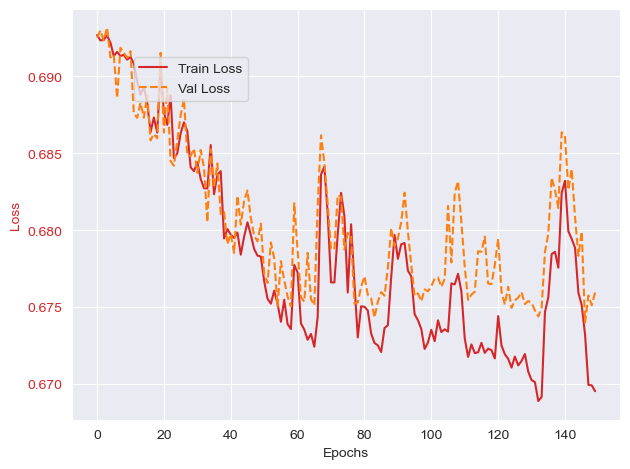

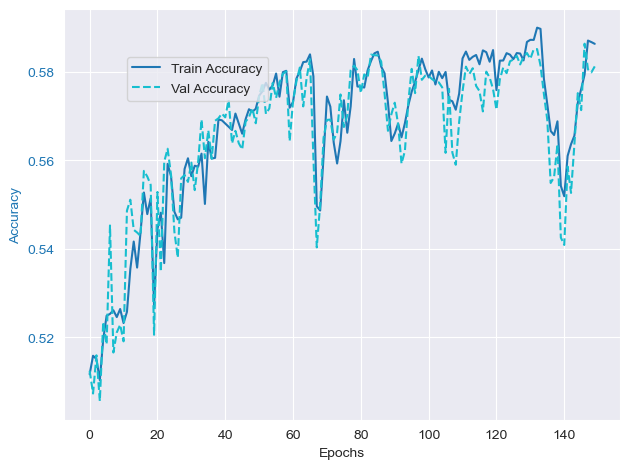

In [5]:
# Helper function to save figures
def save_figure(fig, save_path, save):
    if save:
        fig.savefig(save_path, format='pdf')


# Helper function to plot training and validation loss
def plot_loss(ax, train_loss, val_loss):
    color = 'tab:red'
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss', color=color)
    ax.plot(train_loss, color=color, label='Train Loss')
    ax.plot(val_loss, color='tab:orange', linestyle='--', label='Val Loss')
    ax.tick_params(axis='y', labelcolor=color)
    ax.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))


# Helper function to plot training and validation accuracy
def plot_accuracy(ax, train_acc, val_acc):
    color = 'tab:blue'
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy', color=color)
    ax.plot(train_acc, color=color, label='Train Accuracy')
    ax.plot(val_acc, color='tab:cyan', linestyle='--', label='Val Accuracy')
    ax.tick_params(axis='y', labelcolor=color)
    ax.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))


save = False
# Read the training statistics from the CSV file
#train_stats = pd.read_csv(logger.log_dir + '\\metrics.csv')
train_stats = pd.read_csv('..\\cluster-code\\logs\\stgnn-epochs-150-window-12\\version_1\\metrics.csv')
# Extract loss and accuracy per epoch for both training and validation
train_loss_per_epoch = train_stats['train_loss'].dropna().reset_index(drop=True)
train_acc_per_epoch = train_stats['train_accuracy'].dropna().reset_index(drop=True)
val_loss_per_epoch = train_stats['val_loss'].dropna().reset_index(drop=True)
val_acc_per_epoch = train_stats['val_accuracy'].dropna().reset_index(drop=True)

plot_types = ['one-for-all', 'acc-loss', 'train-val']
plot_type = plot_types[1]
window = 12
if plot_type == 'one-for-all':
    fig, ax1 = plt.subplots()
    plot_loss(ax1, train_loss_per_epoch, val_loss_per_epoch)
    ax2 = ax1.twinx()
    plot_accuracy(ax2, train_acc_per_epoch, val_acc_per_epoch)
    fig.tight_layout()
    figure_savepath = f'../figures/train-stats-space-window-{window}-track-ap2.pdf'
    save_figure(fig, figure_savepath, save)

elif plot_type == 'acc-loss':
    fig_loss, ax1 = plt.subplots()
    plot_loss(ax1, train_loss_per_epoch, val_loss_per_epoch)
    fig_loss.tight_layout()

    loss_figure_savepath = f'../figures/train-stats-space-window-{window}-track-ap2-loss.pdf'
    save_figure(fig_loss, loss_figure_savepath, save)

    fig_acc, ax2 = plt.subplots()
    plot_accuracy(ax2, train_acc_per_epoch, val_acc_per_epoch)
    fig_acc.tight_layout()

    acc_figure_savepath = f'../figures/train-stats-space-window-{window}-track-ap2-accuracy.pdf'
    save_figure(fig_acc, acc_figure_savepath, save)

elif plot_type == 'train-val':
    # Plotting Training Statistics
    fig_train, ax1 = plt.subplots()

    # Plot training loss
    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Training Loss', color=color)
    ax1.plot(train_loss_per_epoch, color=color, label='Train Loss')
    ax1.tick_params(axis='y', labelcolor=color)

    # Create a second y-axis for training accuracy
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Training Accuracy', color=color)
    ax2.plot(train_acc_per_epoch, color=color, label='Train Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)

    # Combine legends from both y-axes
    fig_train.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

    fig_train.tight_layout()

    # Save the training figure based on conditions
    train_figure_savepath = f'../figures/train-stats-space-window-{window}-track-ap2-train.pdf'
    if save:
        plt.savefig(train_figure_savepath, format='pdf')

    # Plotting Validation Statistics
    fig_val, ax3 = plt.subplots()

    # Plot validation loss
    color = 'tab:orange'
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Validation Loss', color=color)
    ax3.plot(val_loss_per_epoch, color=color, linestyle='--', label='Val Loss')
    ax3.tick_params(axis='y', labelcolor=color)

    # Create a second y-axis for validation accuracy
    ax4 = ax3.twinx()
    color = 'tab:cyan'
    ax4.set_ylabel('Validation Accuracy', color=color)
    ax4.plot(val_acc_per_epoch, color=color, linestyle='--', label='Val Accuracy')
    ax4.tick_params(axis='y', labelcolor=color)

    # Combine legends from both y-axes
    fig_val.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

    fig_val.tight_layout()

    # Save the validation figure based on conditions
    val_figure_savepath = f'../figures/train-stats-space-window-{window}-track-ap2-val.pdf'
    if save:
        plt.savefig(val_figure_savepath, format='pdf')

plt.show()

### Evaluate the STGNN

In [68]:
test_dataset = DTDGLinkDataset(test_pos_data, test_neg_data, window=window, horizon=horizon)
test_loader = GDataLoader(test_dataset, shuffle=False, batch_size=1)
trainer.test(stgnn, dataloaders=test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\DMSS_\miniconda3\envs\thesis-code-clone\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.5375046133995056
        test_loss           0.6866307561957571
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.6866307561957571, 'test_accuracy': 0.5375046133995056}]

## Traditional way

In [17]:
def unpack_batch(batch):
    x, edge_index, edge_weight = batch.input.pos_x.unsqueeze(0), batch.edge_index['input_pos_ei'], batch.edge_weight[
        'input_pos_w']
    target_pos_ei, target_neg_ei = batch.edge_index['target_pos_ei'], batch.edge_index['target_neg_ei']
    return x, edge_index, edge_weight, target_pos_ei, target_neg_ei

### Train the STGNN

In epoch 0, loss: 0.6931393432536187, accuracy: 0.5011336803436279
In epoch 5, loss: 0.6927226211358799, accuracy: 0.5119587779045105
In epoch 10, loss: 0.6926543228171409, accuracy: 0.5096782445907593
In epoch 15, loss: 0.6922924936586943, accuracy: 0.514207661151886


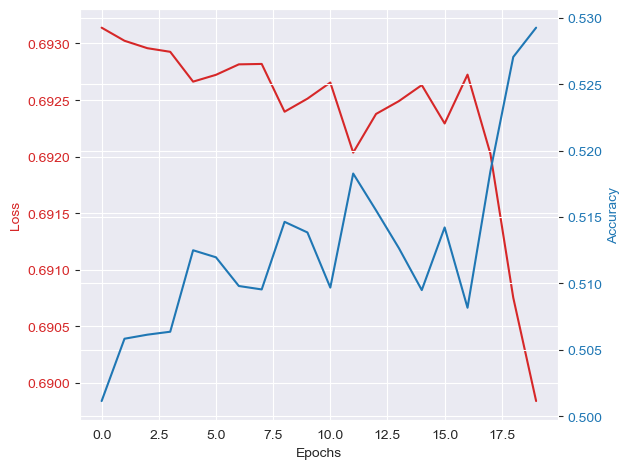

In [195]:
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), clf.parameters()), lr=1e-3)
loss_per_epoch = []
acc_per_epoch = []
for e in tqdm(range(20)):
    model.train()
    loss_s = 0
    acc = 0
    num_batches = 0
    for batch in train_loader:
        # forward
        x, edge_index, edge_weight, target_pos_edge_index, target_neg_edge_index = unpack_batch(batch)
        h = model(x, edge_index, edge_weight)

        pos_score = clf(h.squeeze().squeeze(), target_pos_edge_index)
        neg_score = clf(h.squeeze().squeeze(), target_neg_edge_index)

        loss = compute_loss(pos_score, neg_score)

        # backward
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_s += loss
        acc += ((pos_score >= 0.5).float().sum() + (neg_score < 0.5).float().sum()) / (
                    pos_score.size(0) + neg_score.size(0))
        num_batches += 1

    loss_per_epoch.append((loss_s / num_batches).detach().numpy())
    acc_per_epoch.append((acc / num_batches).detach().numpy())

    if e % 5 == 0:
        print(f"In epoch {e}, loss: {loss_per_epoch[e]}, accuracy: {acc_per_epoch[e]}")

# Plotting
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(loss_per_epoch, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(acc_per_epoch, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()

if reduced:
    figure_savepath = f"../figures/train-stats-window-{window}-space-track-ap2-reduced-{int(frac1 * 100)}.pdf"
elif reduced_sample_alt_e:
    if sampled1:
        figure_savepath = f"../figures/train-stats-window-{window}-space-track-ap2-reduced-{int(frac2 * 100)}-h-{min_alt}-{max_alt}-e-{int(e_thres * 100)}.pdf"
    else:
        figure_savepath = f"../figures/train-stats-window-{window}-space-track-ap2-reduced-h-{min_alt}-{max_alt}-e-{int(e_thres * 100)}.pdf"
elif reduced_sample_leos:
    if sampled2:
        figure_savepath = f"../figures/train-stats-window-{window}-space-track-ap2-{leo}-reduced-{int(frac3 * 100)}.pdf"
    else:
        figure_savepath = f"../figures/train-stats-window-{window}-space-track-ap2-{leo}.pdf"
else:
    figure_savepath = f'../figures/train-stats-space-window-{window}-track-ap2.pdf'

plt.savefig(figure_savepath, format='pdf')
plt.show()

### Evaluate the STGNN

In [196]:
def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]
    ).numpy()
    return roc_auc_score(labels, scores)

In [197]:
model.eval()
test_dataset = DTDGLinkDataset(test_pos_data, test_neg_data, window=window, horizon=horizon)
test_loader = GDataLoader(test_dataset, shuffle=shuffle, batch_size=batch_size)
test_size = len(test_loader)
loss = 0
acc = 0
auc = 0
for batch in tqdm(test_loader):
    # forward
    x, edge_index, edge_weight, target_pos_edge_index, target_neg_edge_index = unpack_batch(batch)
    h = model(x, edge_index, edge_weight)

    pos_score = clf(h.squeeze().squeeze(), target_pos_edge_index).detach()
    neg_score = clf(h.squeeze().squeeze(), target_neg_edge_index).detach()

    loss += compute_loss(pos_score, neg_score)
    acc += (pos_score > 0.5).float().mean()
    auc += compute_auc(pos_score, neg_score)

print(f'Loss:{loss / test_size}\nAccuracy:{acc / test_size}\nAuc:{auc / test_size}\n')

Loss:0.690805624648271
Accuracy:0.8231391906738281
Auc:0.5415016009625238



### Save the model

In [198]:
if reduced:
    model_savepath = f"../models/stgnn-window-{window}-space-track-ap2-reduced-{int(frac1 * 100)}.pth"
elif reduced_sample_alt_e:
    if sampled1:
        model_savepath = f"../models/stgnn-window-{window}-space-track-ap2-reduced-{int(frac2 * 100)}-h-{min_alt}-{max_alt}-e-{int(e_thres * 100)}.pth"
    else:
        model_savepath = f"../models/stgnn-window-{window}-space-track-ap2-reduced-h-{min_alt}-{max_alt}-e-{int(e_thres * 100)}.pth"
elif reduced_sample_leos:
    if sampled2:
        model_savepath = f"../models/stgnn-window-{window}-space-track-ap2-{leo}-reduced-{int(frac3 * 100)}.pth"
    else:
        model_savepath = f"../models/stgnn-window-{window}-space-track-ap2-{leo}.pth"
else:
    model_savepath = f'../models/stgnn-window-{window}-space-track-ap2.pth'
torch.save(model, model_savepath)